In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [3]:
data = pd.read_csv('pre_data.csv')

In [4]:
print(data.head())

         Date  Organization_ID  Energy_Consumption_kWh  Temperature_C  \
0  2021-01-01                7                 1173.57           36.3   
1  2021-01-02                4                  812.70           17.4   
2  2021-01-03                8                  824.89           29.4   
3  2021-01-04                5                 1040.92           13.1   
4  2021-01-05                7                  879.47           17.0   

   Humidity_%  Wind_Speed_kmh  Precipitation_mm Weather_Condition  
0          78            17.7              10.0            Cloudy  
1          21             6.7               2.0            Cloudy  
2          95             8.1               0.0             Snowy  
3          29            11.4               0.0             Sunny  
4          63             3.5               0.0             Rainy  


In [5]:
# Step 2: Select the Energy Consumption column
energy_data = data['Energy_Consumption_kWh']

In [6]:
# Step 3: Preprocess the data
# Reshape data to 2D (if using only energy consumption data for univariate LSTM)
values = energy_data.values.reshape(-1, 1)

In [7]:
# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)

In [8]:
# Create sequences for LSTM (using past n_steps to predict future values)
n_steps = 30  # number of time steps (lags)
X, y = [], []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i-n_steps:i, 0])  # previous n_steps
    y.append(scaled_data[i, 0])  # current value

In [9]:
# Convert to numpy arrays and reshape to (samples, time_steps, features)
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [10]:
# Step 4: Define and Train the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))  # Output layer (1 value)

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Train the model
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 10s 80ms/step - loss: 0.0606 - val_loss: 0.0232
Epoch 2/20
25/25 [==============================] - 2s 75ms/step - loss: 0.0255 - val_loss: 0.0222
Epoch 3/20
25/25 [==============================] - 1s 34ms/step - loss: 0.0250 - val_loss: 0.0210
Epoch 4/20
25/25 [==============================] - 1s 52ms/step - loss: 0.0254 - val_loss: 0.0209
Epoch 5/20
25/25 [==============================] - 1s 28ms/step - loss: 0.0253 - val_loss: 0.0220
Epoch 6/20
25/25 [==============================] - 1s 32ms/step - loss: 0.0250 - val_loss: 0.0213
Epoch 7/20
25/25 [==============================] - 1s 44ms/step - loss: 0.0254 - val_loss: 0.0209
Epoch 8/20
25/25 [==============================] - 1s 26ms/step - loss: 0.0254 - val_loss: 0.0208
Epoch 9/20
25/25 [==============================] - 1s 48ms/step - loss: 0.0248 - val_loss: 0.0209
Epoch 10/20
25/25 [==============================] - 2s 82ms/step - loss: 0.0250 - val_loss: 0.0207
Epoch 11

In [13]:
# Step 5: Make Predictions
# Make predictions on the last part of the data (for the accuracy calculation)
predicted_values = model.predict(X[-len(y):])

31/31 [==============================] - 1s 6ms/step


In [14]:
# Inverse the scaling to get the original scale values
predicted_values = scaler.inverse_transform(predicted_values)

In [15]:
# Step 6: Compare predictions with actual values
actual_values = energy_data.values[n_steps:]  # Actual values

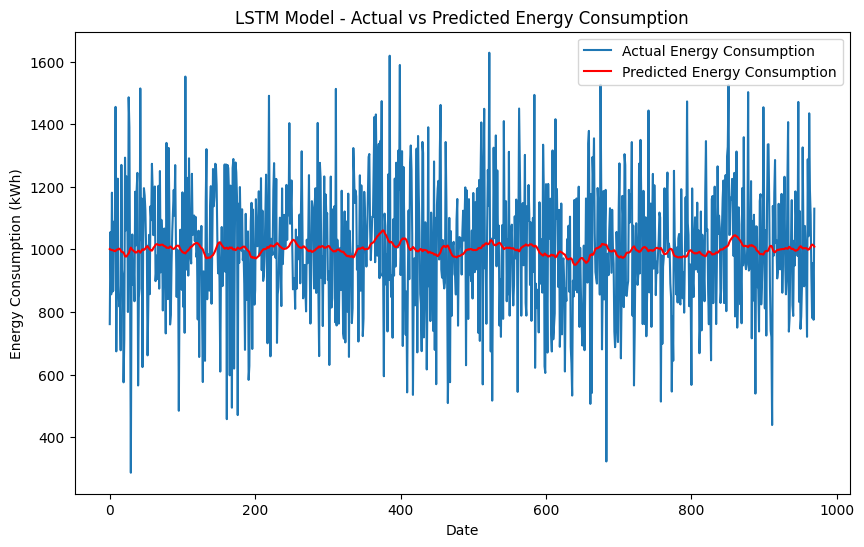

In [16]:
# Step 7: Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Energy Consumption')
plt.plot(predicted_values, label='Predicted Energy Consumption', color='red')
plt.title('LSTM Model - Actual vs Predicted Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()

In [17]:
# Step 8: Calculate accuracy metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

In [18]:
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 164.81259837105347
Mean Squared Error (MSE): 42764.16495314705
Root Mean Squared Error (RMSE): 206.79498290129538


In [19]:
# Step 9: Calculate MAPE and Accuracy
mape = np.mean(np.abs((actual_values - predicted_values.flatten()) / actual_values)) * 100
accuracy = 100 - mape

In [20]:
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Accuracy: {accuracy}%')

Mean Absolute Error (MAE): 164.81259837105347
Mean Squared Error (MSE): 42764.16495314705
Root Mean Squared Error (RMSE): 206.79498290129538
Mean Absolute Percentage Error (MAPE): 18.253166113923992%
Accuracy: 81.746833886076%
